In [1]:
# =========================================================
# 0. PAQUETES Y RUTA BASE
# =========================================================
import os
import glob
import numpy as np
import pandas as pd
import pyreadstat  # importante para .sav y .dta

# Ruta base donde están las carpetas 2021, 2022, 2023, 2024
base_dir = r"C:/Users/jegir/Downloads/SEMINARIO/DATA"

In [2]:
# =========================================================
# 1. FUNCIONES AUXILIARES
# =========================================================

def get_file(year, modulo, pattern):
    """
    Busca dentro de base_dir / year / modulo
    el primer archivo cuyo nombre contenga 'pattern' (case-insensitive).
    """
    year_str = str(year)
    dir_year = os.path.join(base_dir, year_str, modulo)
    files = glob.glob(os.path.join(dir_year, "*"), recursive=False)
    
    # Filtrar por patrón (ignorando mayúsculas/minúsculas)
    files_match = [f for f in files if pattern.lower() in os.path.basename(f).lower()]
    if not files_match:
        raise FileNotFoundError(f"No se encontró archivo en {dir_year} con patrón: {pattern}")
    # Tomamos el primero que coincida
    return files_match[0]


def read_any(path):
    """
    Lector genérico para .dta, .sav, .csv
    usando pyreadstat para evitar problemas de etiquetas/encoding.
    """
    ext = os.path.splitext(path)[1].lower()
    print("Leyendo:", path)
    
    if ext == ".dta":
        df, meta = pyreadstat.read_dta(path, apply_value_formats=False)
        return df
    
    elif ext == ".sav":
        df, meta = pyreadstat.read_sav(path, apply_value_formats=False)
        return df
    
    elif ext == ".csv":
        # Probamos primero coma, luego punto y coma y tab
        for sep in [",", ";", "\t"]:
            for enc in ["latin1", "cp1252"]:
                try:
                    print(f"   Intentando sep='{sep}', encoding='{enc}'...")
                    df = pd.read_csv(
                        path,
                        sep=sep,
                        encoding=enc,
                        engine="python"
                    )
                    print(f"   ✅ Leído OK con sep='{sep}', encoding='{enc}'")
                    return df
                except Exception:
                    continue
        # Si nada funcionó:
        raise ValueError(f"No pude leer el CSV: {path} con los separadores/encodings probados.")
    
    else:
        raise ValueError(f"Extensión no soportada: {ext}")


def prep_mod(df, year):
    """
    - Pone nombres de columnas en minúsculas.
    - Estandariza 'anio', 'conglome', 'vivienda', 'hogar', 'codperso'
    """
    df = df.copy()
    
    # 1) nombres en minúsculas
    df.columns = [c.lower() for c in df.columns]
    
    # 2) estandarizar anio
    if "año" in df.columns and "anio" not in df.columns:
        df = df.rename(columns={"año": "anio"})
    if "ano" in df.columns and "anio" not in df.columns:
        df = df.rename(columns={"ano": "anio"})
    if "anio" not in df.columns:
        df["anio"] = year
    else:
        # por si trae otros años raros
        df["anio"] = year
    
    # 3) estandarizar llaves
    rename_map = {}
    for k in ["conglome", "vivienda", "hogar", "codperso"]:
        for var in [k, k.upper(), k.capitalize()]:
            if var in df.columns and k not in df.columns:
                rename_map[var] = k
    if rename_map:
        df = df.rename(columns=rename_map)
    
    return df


def keep_vars(df, vars_list, year, nombre_mod):
    """
    Se queda sólo con las columnas de vars_list que realmente existan en df.
    """
    cols = [c for c in vars_list if c in df.columns]
    print(f"{nombre_mod} {year}: conservo {len(cols)} variables.")
    return df[cols].copy()


def build_mod77_year(year, df_1_13, df_24):
    """
    Construye una base por año del módulo 77 con:
    - llaves (anio, conglome, vivienda, hogar, codperso)
    - variables del negocio (e1, e8a, e8b, e8c, etc.)
    - e24h (seguro de salud en el empleo)
    
    ⚠ OJO: AQUÍ NO SE CONSTRUYE LA VARIABLE 'informal'.
    La variable 'informal' se construirá después, combinando:
      - p599 (dependiente/independiente)
      - e1  (registro del negocio)
      - e24h (seguro en el empleo)
      - p558a1–p558a5 (pensiones)
    """
    keys = ["conglome", "vivienda", "hogar", "codperso"]
    
    d1 = prep_mod(df_1_13, year)
    d2 = prep_mod(df_24, year)
    
    # asegurar que las llaves existen
    for k in keys:
        if k not in d1.columns or k not in d2.columns:
            raise KeyError(f"Falta la llave '{k}' en módulo 77 año {year}.")
    
    # pasar llaves a string para evitar problemas de tipos
    for k in keys:
        d1[k] = d1[k].astype(str)
        d2[k] = d2[k].astype(str)
    
    # columnas relevantes de d1 (negocio)
    cand_cols_1 = [
        "e1", "e1a1", "e1b",
        "e2", "e3",
        "e6a", "e6b",
        "e8a", "e8b", "e8c",
        "e14t", "e17t", "e20t",
        "e24t",
        "e25t1", "e25t2", "e25t3"
    ]
    cols_1 = keys + [c for c in cand_cols_1 if c in d1.columns]
    d1_sub = d1[cols_1].copy()
    
    # en caso de duplicados por persona, tomamos el primero (simplificación)
    d1_g = d1_sub.groupby(keys, as_index=False).first()
    
    # de d2 nos interesa e24h (seguro en el empleo); si hay varias filas, tomamos el mínimo (1 = tiene seguro; 2+ = no)
    if "e24h" in d2.columns:
        d2_sub = d2[keys + ["e24h"]].copy()
        d2_g = d2_sub.groupby(keys, as_index=False)["e24h"].min()
    else:
        d2_g = d2[keys].drop_duplicates().copy()
        d2_g["e24h"] = np.nan
    
    # merge
    m77 = d1_g.merge(d2_g, on=keys, how="left")
    
    # anio
    m77["anio"] = year

    # variables auxiliares (no es la informalidad final)
    # negocio_registrado: 1 = sí, 0 = no/otro, NaN = no sabe/no declarado
    if "e1" in m77.columns:
        m77["negocio_registrado"] = np.where(
            m77["e1"] == 1, 1,
            np.where(m77["e1"].isin([2, 3, 4, 9]), 0, np.nan)
        )
    else:
        m77["negocio_registrado"] = np.nan

    # tiene_seguro_empleo: 1 = sí, 0 = no, NaN = no sabe/no declarado
    m77["tiene_seguro_empleo"] = np.where(
        m77["e24h"] == 1, 1,
        np.where(m77["e24h"].isin([2, 3, 4, 5, 9]), 0, np.nan)
    )
    
    return m77


# --- NUEVO: filtrar sólo las columnas relevantes del MÓDULO 3 ---
def filtrar_modulo3(df, vars_mod3):
    """
    Recibe el módulo 3 ya con nombres estandarizados (lower)
    y devuelve sólo las columnas que nos interesan.
    """
    vars_lower = [v.lower() for v in vars_mod3]
    disponibles = [c for c in df.columns if c in vars_lower]

    faltantes = set(vars_lower) - set(disponibles)
    if faltantes:
        print(f"⚠ Columnas del módulo 3 que no están en este año: {faltantes}")

    return df[disponibles]


In [3]:
# =========================================================
# 2. LECTURA DE MÓDULOS 2021–2024
# =========================================================

# ---------- 2021 ----------
mod1_2021 = read_any(get_file(2021, "Modulo01", "100"))
mod2_2021 = read_any(get_file(2021, "Modulo02", "200"))
mod3_2021 = read_any(get_file(2021, "Modulo03", "300.sav"))   # archivo principal
mod4_2021 = read_any(get_file(2021, "Modulo04", "400"))
mod5_2021 = read_any(get_file(2021, "Modulo05", "500"))
sumaria_2021 = read_any(get_file(2021, "Modulo34", "sumaria-2021"))
mod77_1_13_2021 = read_any(get_file(2021, "Modulo77", "1-preg-1-a-13"))
mod77_24_2021   = read_any(get_file(2021, "Modulo77", "4-preg-24"))

# ---------- 2022 ----------
mod1_2022 = read_any(get_file(2022, "Modulo01", "100"))
mod2_2022 = read_any(get_file(2022, "Modulo02", "200"))
mod3_2022 = read_any(get_file(2022, "Modulo03", "300"))
mod4_2022 = read_any(get_file(2022, "Modulo04", "400"))
mod5_2022 = read_any(get_file(2022, "Modulo05", "500"))
sumaria_2022 = read_any(get_file(2022, "Modulo34", "sumaria-2022"))
mod77_1_13_2022 = read_any(get_file(2022, "Modulo77", "1-preg-1-a-13"))
mod77_24_2022   = read_any(get_file(2022, "Modulo77", "4-preg-24"))

# ---------- 2023 ----------
mod1_2023 = read_any(get_file(2023, "Modulo01", "100"))
mod2_2023 = read_any(get_file(2023, "Modulo02", "200"))
mod3_2023 = read_any(get_file(2023, "Modulo03", "300"))
mod4_2023 = read_any(get_file(2023, "Modulo04", "400"))
mod5_2023 = read_any(get_file(2023, "Modulo05", "500"))
sumaria_2023 = read_any(get_file(2023, "Modulo34", "sumaria-2023"))
mod77_1_13_2023 = read_any(get_file(2023, "Modulo77", "1-preg-1-a-13"))
mod77_24_2023   = read_any(get_file(2023, "Modulo77", "4-preg-24"))

# ---------- 2024 ----------
mod1_2024 = read_any(get_file(2024, "Modulo01", "100"))
mod2_2024 = read_any(get_file(2024, "Modulo02", "200"))
mod3_2024 = read_any(get_file(2024, "Modulo03", "300"))
mod4_2024 = read_any(get_file(2024, "Modulo04", "400"))
mod5_2024 = read_any(get_file(2024, "Modulo05", "500"))
sumaria_2024 = read_any(get_file(2024, "Modulo34", "sumaria-2024"))
mod77_1_13_2024 = read_any(get_file(2024, "Modulo77", "1-preg-1-a-13"))
mod77_24_2024   = read_any(get_file(2024, "Modulo77", "4-preg-24"))

Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo01\enaho01-2021-100.dta
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo02\enaho01-2021-200.sav
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo03\enaho01a-2021-300.sav
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo04\ENAHO01a-2021-400.sav
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo05\ENAHO01a-2021-500.dta
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo34\sumaria-2021-12g.dta
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo77\ENAHO04-2021-1-preg-1-a-13.dta
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2021\Modulo77\ENAHO04-2021-4-preg-24.dta
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2022\Modulo01\Enaho01-2022-100.sav
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\2022\Modulo02\Enaho01-2022-200.csv
   Intentando sep=',', encoding='latin1'...
   ✅ Leído OK con sep=',', encoding='latin1'
Leyendo: C:/Users/jegir/Downloads/SEMINARIO/DATA\202

In [4]:
# =========================================================
# 3. PREPARAR MÓDULOS (NOMBRES, LLAVES, AÑO)
#    Y CONSTRUIR MOD77 POR AÑO
# =========================================================

# --- Módulos 1, 2, 3, 4, 5, sumaria ---
mod1_2021_p = prep_mod(mod1_2021, 2021)
mod2_2021_p = prep_mod(mod2_2021, 2021)
mod3_2021_p = prep_mod(mod3_2021, 2021)
mod4_2021_p = prep_mod(mod4_2021, 2021)
mod5_2021_p = prep_mod(mod5_2021, 2021)
sumaria_2021_p = prep_mod(sumaria_2021, 2021)

mod1_2022_p = prep_mod(mod1_2022, 2022)
mod2_2022_p = prep_mod(mod2_2022, 2022)
mod3_2022_p = prep_mod(mod3_2022, 2022)
mod4_2022_p = prep_mod(mod4_2022, 2022)
mod5_2022_p = prep_mod(mod5_2022, 2022)
sumaria_2022_p = prep_mod(sumaria_2022, 2022)

mod1_2023_p = prep_mod(mod1_2023, 2023)
mod2_2023_p = prep_mod(mod2_2023, 2023)
mod3_2023_p = prep_mod(mod3_2023, 2023)
mod4_2023_p = prep_mod(mod4_2023, 2023)
mod5_2023_p = prep_mod(mod5_2023, 2023)
sumaria_2023_p = prep_mod(sumaria_2023, 2023)

mod1_2024_p = prep_mod(mod1_2024, 2024)
mod2_2024_p = prep_mod(mod2_2024, 2024)
mod3_2024_p = prep_mod(mod3_2024, 2024)
mod4_2024_p = prep_mod(mod4_2024, 2024)
mod5_2024_p = prep_mod(mod5_2024, 2024)
sumaria_2024_p = prep_mod(sumaria_2024, 2024)

# --- Módulo 77 (negocio + informalidad) ---
mod77_joined_2021 = build_mod77_year(2021, mod77_1_13_2021, mod77_24_2021)
mod77_joined_2022 = build_mod77_year(2022, mod77_1_13_2022, mod77_24_2022)
mod77_joined_2023 = build_mod77_year(2023, mod77_1_13_2023, mod77_24_2023)
mod77_joined_2024 = build_mod77_year(2024, mod77_1_13_2024, mod77_24_2024)


In [5]:
# =========================================================
# 4. VARIABLES CLAVE POR MÓDULO
# =========================================================

# Módulo 1 – contexto del hogar
vars_mod1 = [
    "anio","conglome","vivienda","hogar",
    "ubigeo","dominio","estrato",
    "p101","p102","p103","p103a",
    "p104","p104a","nbi2",
    "p105a","p106a","p106b",
    "p110","p111a","p1121","p1142","p1144",
    "nbi1","nbi2","nbi3","nbi4","nbi5"
]

# Módulo 2 – demografía básica / ocupación
vars_mod2 = [
    "anio","conglome","vivienda","hogar","codperso",
    "p207","p208a","p209",
    "p210","p211a","p211d",
    "ocupac_r3","ocupac_r4","rama_r3","rama_r4"
]

# Módulo 3 - Educación
vars_mod3 = [
    "anio","conglome","vivienda","hogar","codperso",
    "p301a","p301b","p301c","p301d",
    "p302","p303","p304","p305","p309",
    "p308",
    "p314a","p314b","p314d",
    "p316a1","p316a2","p316a3","p316a4","p316a5","p316a6",
    "p316b",
    "p316c1","p316c2","p316c3","p316c4","p316c5",
    "p316c6","p316c7","p316c8","p316c9","p316c10",
    "factor07","nconglome","sub_conglome"
]

# Módulo 4 – salud / discapacidad / seguro
vars_mod4 = [
    "anio","conglome","vivienda","hogar","codperso",
    "ubigeo","dominio","estrato",
    "nconglome","sub_conglome","factor07",
    "p401c","p401",
    "p401h1","p401h2","p401h3","p401h4","p401h5","p401h6",
    "p4021","p4022","p4023","p4024","p4025","p4026",
    "p401f","p401g1","p401g2",
    "p407g1","p407g2","p407g3",
    "p4091","p4092","p4093","p4094","p4095",
    "p4096","p4097","p4098","p4099","p40910","p40911",
    "p420a","p420b",
    "p4191","p4192","p4193","p4194",
    "p4195","p4196","p4197","p4198",
    "p419a1","p419a2","p419a3","p419a4",
    "p419a5","p419a6","p419a7","p419a8"
]

# Módulo 5 – empleo / ingresos / pensiones
vars_mod5 = [
    "anio","conglome","vivienda","hogar","codperso",
    "p207","p208a","p209","p203",
    "p599","ocu500",
    "i518","i513t","i520",
    "i524","i538","d524","d538",
    "i541a","i530a",
    "p558a1","p558a2","p558a3","p558a4","p558a5",
    "p558b1","p558b2","p558b3",
    "p558e","p558f","p558g","p558h"
]

# Sumaria – pobreza / estrato socioeconómico
vars_sumaria = [
    "anio","conglome","vivienda","hogar",
    "estrsocial","ld","linpe","linea",
    "pobreza","lineav","pobrezav"
]

# Módulo 77 – variables del negocio (SIN informalidad)
vars_mod77 = [
    "anio","conglome","vivienda","hogar","codperso",
    "e1","e1a1","e1b",
    "e2","e3",
    "e6a","e6b",
    "e8a","e8b","e8c",
    "e14t","e17t","e20t",
    "e24t",
    "e25t1","e25t2","e25t3",
    "e24h"
]


In [6]:
# =========================================================
# 5. ARMADO DE BASES POR MÓDULO (2021–2024)
# =========================================================

# ---------- Módulo 1 ----------
mod1_2021_small = keep_vars(mod1_2021_p, vars_mod1, 2021, "mod1")
mod1_2022_small = keep_vars(mod1_2022_p, vars_mod1, 2022, "mod1")
mod1_2023_small = keep_vars(mod1_2023_p, vars_mod1, 2023, "mod1")
mod1_2024_small = keep_vars(mod1_2024_p, vars_mod1, 2024, "mod1")

mod1_all = pd.concat(
    [mod1_2021_small, mod1_2022_small, mod1_2023_small, mod1_2024_small],
    ignore_index=True
)
print("mod1_all:", mod1_all.shape)

# ---------- Módulo 2 ----------
mod2_2021_small = keep_vars(mod2_2021_p, vars_mod2, 2021, "mod2")
mod2_2022_small = keep_vars(mod2_2022_p, vars_mod2, 2022, "mod2")
mod2_2023_small = keep_vars(mod2_2023_p, vars_mod2, 2023, "mod2")
mod2_2024_small = keep_vars(mod2_2024_p, vars_mod2, 2024, "mod2")

mod2_all = pd.concat(
    [mod2_2021_small, mod2_2022_small, mod2_2023_small, mod2_2024_small],
    ignore_index=True
)
print("mod2_all:", mod2_all.shape)

# ---------- Módulo 3 ----------
mod3_2021_small = keep_vars(mod3_2021_p, vars_mod3, 2021, "mod3")
mod3_2022_small = keep_vars(mod3_2022_p, vars_mod3, 2022, "mod3")
mod3_2023_small = keep_vars(mod3_2023_p, vars_mod3, 2023, "mod3")
mod3_2024_small = keep_vars(mod3_2024_p, vars_mod3, 2024, "mod3")

mod3_all = pd.concat(
    [mod3_2021_small, mod3_2022_small, mod3_2023_small, mod3_2024_small],
    ignore_index=True
)
print("mod3_all:", mod3_all.shape)


# ---------- Módulo 5 ----------
mod5_2021_small = keep_vars(mod5_2021_p, vars_mod5, 2021, "mod5")
mod5_2022_small = keep_vars(mod5_2022_p, vars_mod5, 2022, "mod5")
mod5_2023_small = keep_vars(mod5_2023_p, vars_mod5, 2023, "mod5")
mod5_2024_small = keep_vars(mod5_2024_p, vars_mod5, 2024, "mod5")

mod5_all = pd.concat(
    [mod5_2021_small, mod5_2022_small, mod5_2023_small, mod5_2024_small],
    ignore_index=True
)
print("mod5_all:", mod5_all.shape)

# ---------- Sumaria ----------
sumaria_2021_small = keep_vars(sumaria_2021_p, vars_sumaria, 2021, "sumaria")
sumaria_2022_small = keep_vars(sumaria_2022_p, vars_sumaria, 2022, "sumaria")
sumaria_2023_small = keep_vars(sumaria_2023_p, vars_sumaria, 2023, "sumaria")
sumaria_2024_small = keep_vars(sumaria_2024_p, vars_sumaria, 2024, "sumaria")

sumaria_all = pd.concat(
    [sumaria_2021_small, sumaria_2022_small, sumaria_2023_small, sumaria_2024_small],
    ignore_index=True
)
print("sumaria_all:", sumaria_all.shape)

# ---------- Módulo 77 (negocio + seguro de empleo) ----------
m77_2021_small = keep_vars(mod77_joined_2021, vars_mod77, 2021, "mod77")
m77_2022_small = keep_vars(mod77_joined_2022, vars_mod77, 2022, "mod77")
m77_2023_small = keep_vars(mod77_joined_2023, vars_mod77, 2023, "mod77")
m77_2024_small = keep_vars(mod77_joined_2024, vars_mod77, 2024, "mod77")

mod77_all = pd.concat(
    [m77_2021_small, m77_2022_small, m77_2023_small, m77_2024_small],
    ignore_index=True
)
print("mod77_all:", mod77_all.shape)



mod1 2021: conservo 27 variables.
mod1 2022: conservo 27 variables.
mod1 2023: conservo 27 variables.
mod1 2024: conservo 27 variables.
mod1_all: (176755, 27)
mod2 2021: conservo 15 variables.
mod2 2022: conservo 15 variables.
mod2 2023: conservo 15 variables.
mod2 2024: conservo 1 variables.
mod2_all: (362106, 15)
mod3 2021: conservo 34 variables.
mod3 2022: conservo 34 variables.
mod3 2023: conservo 34 variables.
mod3 2024: conservo 34 variables.
mod3_all: (435097, 34)
mod5 2021: conservo 24 variables.
mod5 2022: conservo 24 variables.
mod5 2023: conservo 24 variables.
mod5 2024: conservo 24 variables.
mod5_all: (347113, 24)
sumaria 2021: conservo 11 variables.
sumaria 2022: conservo 11 variables.
sumaria 2023: conservo 11 variables.
sumaria 2024: conservo 11 variables.
sumaria_all: (136035, 11)
mod77 2021: conservo 23 variables.
mod77 2022: conservo 23 variables.
mod77 2023: conservo 23 variables.
mod77 2024: conservo 23 variables.
mod77_all: (72263, 23)


In [7]:
# =========================================================
# 6. BASE UNIFICADA DE TRABAJADORES (2021–2024)
# =========================================================

# Clave a nivel persona
keys_persona = ["anio", "conglome", "vivienda", "hogar", "codperso"]
keys_hogar   = ["anio", "conglome", "vivienda", "hogar"]

# =========================================================
# 6.1 CONVERTIR TODAS LAS LLAVES A STRING EN TODOS LOS MÓDULOS
# =========================================================

# Lista completa de módulos a estandarizar
modulos = [
    mod1_all,
    mod2_all,
    mod3_all,
    mod4_all if 'mod4_all' in globals() else None,  # por si luego usamos módulo 4
    mod5_all,
    mod77_all,
    sumaria_all
]

for df in modulos:
    if df is None:
        continue
    for k in keys_persona + keys_hogar:
        if k in df.columns:
            df[k] = df[k].astype(str)

# =========================================================
# 6.2 FUNCIÓN DE MERGE SEGURO
# =========================================================

def merge_keep_new(base, other, on, how="left"):
    cols_base = set(base.columns)
    # Conservamos las llaves + columnas nuevas que aún no están en la base
    keep_cols = [c for c in other.columns if (c in on) or (c not in cols_base)]
    return base.merge(other[keep_cols], on=on, how=how)

# =========================================================
# 6.3 ARMAMOS LA BASE CENTRAL (mod5 como base laboral)
# =========================================================

base = mod5_all.copy()

# Módulo 2: sociodemografía
base = merge_keep_new(base, mod2_all, on=keys_persona, how="left")

# Módulo 3: educación y TIC
base = merge_keep_new(base, mod3_all, on=keys_persona, how="left")

# Módulo 77: negocio + seguro de empleo (NO informalidad aún)
base = merge_keep_new(base, mod77_all, on=keys_persona, how="left")

# Módulo 1: características del hogar
base = merge_keep_new(base, mod1_all, on=keys_hogar, how="left")

# Sumaria: pobreza y estrato socioeconómico
base = merge_keep_new(base, sumaria_all, on=keys_hogar, how="left")

print("Base unificada (antes de filtros):", base.shape)


Base unificada (antes de filtros): (347113, 110)


In [8]:
# =========================================================
# 7. INFORMALIDAD 100% CORRECTA (CON P558a1–P558a5)
# =========================================================

df = base.copy()

df["p599"] = pd.to_numeric(df["p599"], errors="coerce")
df["e1"]   = pd.to_numeric(df["e1"], errors="coerce")

# Convertir pensiones a numérico
pension_cols = ["p558a1","p558a2","p558a3","p558a4","p558a5"]
for c in pension_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["trabaja"] = df["p599"].isin([1,2,3]).astype(int)

# Inicializar
df["informal"] = np.nan

# 1) DEPENDIENTES
dep = df["p599"] == 1
df.loc[dep, "informal"] = np.where(
    df.loc[dep, pension_cols].fillna(0).sum(axis=1) > 0,
    0,  # formal
    1   # informal
)

# 2) INDEPENDIENTES
ind = df["p599"] == 2
df.loc[ind, "informal"] = np.where(
    df.loc[ind, "e1"].isin([1,2]),
    0,  # formal
    1   # informal
)

# 3) NO REMUNERADOS
df.loc[df["p599"] == 3, "informal"] = 1

# Filtrar trabajadores válidos
trab = df[(df["trabaja"] == 1) & (df["informal"].isin([0,1]))].copy()

print("Trabajadores filtrados:", trab.shape)
print(trab["informal"].value_counts(dropna=False))


Trabajadores filtrados: (72938, 112)
informal
0.0    56433
1.0    16505
Name: count, dtype: int64


In [9]:
# =====================================
# RECONSTRUCCIÓN CORRECTA DE INFORMALIDAD
# =====================================

df = base.copy()

# Aseguramos que p599 sea numérica
df["p599"] = pd.to_numeric(df["p599"], errors="coerce")

# --- 1. Dependientes (p599 == 1) ---
pension_cols = ["p558a1","p558a2","p558a3","p558a4","p558a5"]

for col in pension_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# afiliado a algún sistema de pensiones (1 si al menos una es == 1)
df["afil_pension"] = df[pension_cols].eq(1).any(axis=1).astype("Int64")

# inicializamos informal como NA
df["informal"] = pd.NA

# máscara dependientes
mask_dep = df["p599"] == 1
df.loc[mask_dep, "informal"] = np.where(
    df.loc[mask_dep, "afil_pension"] == 1,
    0,  # formal
    1   # informal
)

# --- 2. Independientes (p599 == 2 o 3) ---
df["e1"] = pd.to_numeric(df["e1"], errors="coerce")
mask_indep = df["p599"].isin([2, 3])

df.loc[mask_indep, "informal"] = np.where(
    df.loc[mask_indep, "e1"].isin([1, 2]),
    0,  # formal (negocio registrado)
    1   # informal
)

# pasamos a entero con NA permitido
df["informal"] = df["informal"].astype("Int64")

# --- 3. Filtramos ocupados con informalidad definida ---
trab = df[
    df["p599"].isin([1, 2, 3]) &
    df["informal"].isin([0, 1])
].copy()

print("Dimensión de trab:", trab.shape)
print(trab["informal"].value_counts(dropna=False))



Dimensión de trab: (72938, 112)
informal
1    63648
0     9290
Name: count, dtype: Int64


In [10]:
print("INFORMALIDAD GLOBAL:")
print(trab["informal"].value_counts(dropna=False))

print("\nDependientes (p599==1):")
print(trab.loc[trab["p599"]==1, "informal"].value_counts(dropna=False))

print("\nIndependientes (p599 in {2,3}):")
print(trab.loc[trab["p599"].isin([2,3]), "informal"].value_counts(dropna=False))


INFORMALIDAD GLOBAL:
informal
1    63648
0     9290
Name: count, dtype: Int64

Dependientes (p599==1):
informal
1    48002
0     7272
Name: count, dtype: Int64

Independientes (p599 in {2,3}):
informal
1    15646
0     2018
Name: count, dtype: Int64


In [11]:
# =========================================================
# 8. VARIABLES DERIVADAS
# =========================================================

df = trab  # para escribir más corto

# 1. SEXO (0 mujer, 1 hombre)
df["sexo"] = df["p207"].replace({1: 1, 2: 0})

# 2. EDAD Y GRUPO DE EDAD
df["edad"] = pd.to_numeric(df["p208a"], errors="coerce")
df["edad_grupo"] = pd.cut(
    df["edad"],
    bins=[0, 24, 44, 64, 120],
    labels=["joven", "adulto", "maduro", "mayor"]
)

# 3. EDUCACIÓN RESUMIDA
df["edu_nivel"] = df["p301d"].map({
    1: "sin_nivel",
    2: "primaria",
    3: "secundaria",
    4: "tecnica",
    5: "superior",
    6: "posgrado"
})

# 4. CONDICIÓN LABORAL: dependiente / independiente
df["indep"] = df["p599"].map({1: 0, 2: 1, 3: 1})

# 5. HORAS TRABAJADAS (ocupación principal)
df["horas_semana"] = pd.to_numeric(df["p211d"], errors="coerce")

# 6. INGRESO LABORAL (log) -- versión segura
ing_vars = ["i524", "i538", "d524", "d538", "i520", "i513t"]
df["ingreso_laboral"] = np.nan

for v in ing_vars:
    if v in df.columns:
        df["ingreso_laboral"] = df["ingreso_laboral"].fillna(
            pd.to_numeric(df[v], errors="coerce")
        )

df["log_ingreso"] = np.log(df["ingreso_laboral"] + 1)

# 7. REGIÓN Y RURAL/URBANO
df["region"] = df["ubigeo"].str[:2]

# rural según ENAHO: dominios 3 y 4
df["dominio_num"] = pd.to_numeric(df["dominio"], errors="coerce")
df["rural"] = df["dominio_num"].isin([3, 4]).astype(int)

# 8. RAMA de actividad (nivel 1) — versión segura
df["rama1"] = pd.to_numeric(df["rama_r4"], errors="coerce") // 10
df["rama1"] = df["rama1"].astype("Int64")

# 9. TAMAÑO DEL NEGOCIO
df["num_trab"] = df[["e8a", "e8b", "e8c"]].apply(
    lambda r: pd.to_numeric(r, errors="coerce").sum(),
    axis=1
)

# 10. EXPERIENCIA EN EL NEGOCIO (años)
df["exp_negocio"] = pd.to_numeric(df["e6a"], errors="coerce")

# 11. EDUCACIÓN BINARIA: superior/no superior
df["edu_sup"] = df["edu_nivel"].isin(["tecnica", "superior", "posgrado"]).astype(int)

# 12. HORAS EXCESIVAS (≥48 semanales)
df["horas_ext"] = (df["horas_semana"] >= 48).astype(int)

# Actualizamos en el objeto principal
trab = df.copy()

print("Variables derivadas agregadas. Filas:", trab.shape)

# =========================================================
# 8.X VARIABLES DERIVADAS ADICIONALES (SEGÚN MATRIZ DE CONSISTENCIA)
# =========================================================

# ---- 1. SECTOR ECONÓMICO (primario / secundario / terciario)
# Usamos rama_r4 (CIIU Rev.4)
df["rama_r4_num"] = pd.to_numeric(df["rama_r4"], errors="coerce")

def clasificar_sector(cod):
    if pd.isna(cod):
        return np.nan
    if 1 <= cod <= 3:   # Agricultura, pesca, minería
        return "primario"
    if 4 <= cod <= 9:   # Manufactura, construcción, electricidad, agua
        return "secundario"
    if 10 <= cod <= 33: # Comercio, transporte, servicios, administración
        return "terciario"
    return np.nan

df["sector_economico"] = df["rama_r4_num"].apply(clasificar_sector)

# ---- 2. TAMAÑO DE EMPRESA (SOLO PARA DEPENDIENTES)
# p507t = tamaño del empleador en muchos años ENAHO (si existe)
if "p507t" in df.columns:
    df["p507t_num"] = pd.to_numeric(df["p507t"], errors="coerce")

    def clasificar_tamano_emp(n):
        if pd.isna(n):
            return np.nan
        if n <= 10:
            return "micro"
        if n <= 50:
            return "pequena"
        if n <= 250:
            return "mediana"
        return "grande"

    # Solo aplicar si trabajador es dependiente
    df["tamano_empresa"] = np.where(
        df["p599"] == 1,
        df["p507t_num"].apply(clasificar_tamano_emp),
        np.nan
    )
else:
    print("⚠ No existe p507t en la base. Tamaño empresa solo para independientes con e8a+e8b+e8c.")

    # Para independientes, usamos número de trabajadores del negocio
    def clasif_indep(n):
        if pd.isna(n):
            return np.nan
        if n <= 10:
            return "micro"
        if n <= 50:
            return "pequena"
        if n <= 250:
            return "mediana"
        return "grande"

    df["tamano_empresa"] = df["num_trab"].apply(clasif_indep)

# ---- 3. MACROREGIÓN (Costa / Sierra / Selva)
# Map basado en departamentos según ENAHO
macro_map = {
    "01":"Costa", "02":"Costa", "03":"Sierra", "04":"Sierra",
    "05":"Sierra", "06":"Sierra", "07":"Costa", "08":"Costa",
    "09":"Sierra", "10":"Sierra", "11":"Selva", "12":"Selva",
    "13":"Selva", "14":"Costa", "15":"Costa", "16":"Selva",
    "17":"Selva", "18":"Selva", "19":"Selva", "20":"Sierra",
    "21":"Sierra", "22":"Sierra", "23":"Costa", "24":"Sierra"
}

df["departamento"] = df["ubigeo"].str[:2]
df["macroregion"] = df["departamento"].map(macro_map)

# ---- ACTUALIZAR "trab"
trab = df.copy()

print("Variables adicionales agregadas: sector_economico, tamano_empresa, macroregion")



Variables derivadas agregadas. Filas: (72938, 128)
⚠ No existe p507t en la base. Tamaño empresa solo para independientes con e8a+e8b+e8c.
Variables adicionales agregadas: sector_economico, tamano_empresa, macroregion


In [12]:
# =========================================================
# 9. DESCRIPTIVOS DE INFORMALIDAD
# =========================================================

# 9.1 PREVALENCIA GLOBAL (no ponderada)
prev_global = trab["informal"].mean()
print(f"Prevalencia de informalidad (2021–2024): {prev_global:.3f}")

# 9.2 PREVALENCIA POR SEXO
tabla_sexo = (
    trab
    .groupby("sexo", dropna=False)["informal"]
    .agg(['mean', 'size'])
    .reset_index()
)
tabla_sexo["sexo_label"] = tabla_sexo["sexo"].map({1: "Hombre", 0: "Mujer", np.nan: "ND"})
print("\nPrevalencia de informalidad por sexo:")
print(tabla_sexo[["sexo_label", "mean", "size"]])

# 9.3 PREVALENCIA POR GRUPO DE EDAD
tabla_edad = (
    trab
    .groupby("edad_grupo", dropna=False)["informal"]
    .agg(['mean', 'size'])
    .reset_index()
)
print("\nPrevalencia de informalidad por grupo de edad:")
print(tabla_edad)

# 9.4 PREVALENCIA POR NIVEL EDUCATIVO
tabla_edu = (
    trab
    .groupby("edu_nivel", dropna=False)["informal"]
    .agg(['mean', 'size'])
    .reset_index()
    .sort_values("mean", ascending=False)
)
print("\nPrevalencia de informalidad por nivel educativo:")
print(tabla_edu)

# 9.5 PREVALENCIA POR ÁMBITO (URBANO/RURAL)
tabla_rural = (
    trab
    .groupby("rural", dropna=False)["informal"]
    .agg(['mean', 'size'])
    .reset_index()
)
tabla_rural["ambito"] = tabla_rural["rural"].map({1: "Rural", 0: "Urbano", np.nan: "ND"})
print("\nPrevalencia de informalidad por ámbito:")
print(tabla_rural[["ambito", "mean", "size"]])

# 9.6 PREVALENCIA POR AÑO
tabla_anio = (
    trab
    .groupby("anio", dropna=False)["informal"]
    .agg(['mean', 'size'])
    .reset_index()
    .sort_values("anio")
)
print("\nPrevalencia de informalidad por año:")
print(tabla_anio)

# 9.7 (OPCIONAL) PREVALENCIA PONDERADA SI EXISTE FACTOR07
if "factor07" in trab.columns:
    trab["factor07_num"] = pd.to_numeric(trab["factor07"], errors="coerce")

    def wmean(x):
        w = x["factor07_num"]
        y = x["informal"]
        mask = (~w.isna()) & (~y.isna()) & (w > 0)
        if mask.sum() == 0:
            return np.nan
        return np.average(y[mask], weights=w[mask])

    prev_global_w = wmean(trab)
    print(f"\nPrevalencia global ponderada por factor07: {prev_global_w:.3f}")


Prevalencia de informalidad (2021–2024): 0.873

Prevalencia de informalidad por sexo:
  sexo_label      mean   size
0      Mujer   0.91376  39390
1     Hombre  0.824341  33548

Prevalencia de informalidad por grupo de edad:
  edad_grupo      mean   size
0      joven  0.933458   5365
1     adulto  0.845131  29625
2     maduro  0.872316  29941
3      mayor  0.934807   8007

Prevalencia de informalidad por nivel educativo:
   edu_nivel      mean   size
1  sin_nivel  0.891386  43300
2        NaN  0.882613  20113
0   primaria  0.766299   9525

Prevalencia de informalidad por ámbito:
   ambito      mean   size
0  Urbano  0.876029  64265
1   Rural  0.847458   8673

Prevalencia de informalidad por año:
   anio      mean   size
0  2021  0.869998  17192
1  2022  0.873716  18593
2  2023  0.873504  18712
3  2024  0.873109  18441

Prevalencia global ponderada por factor07: 0.877


C:\Users\jegir\AppData\Local\Temp\ipykernel_984\4242174379.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("edad_grupo", dropna=False)["informal"]


In [13]:
# =========================================================
# CREAR VARIABLES CONTEXTUALES FALTANTES: sector y macroregión
# =========================================================

df = trab.copy()

# ---------------------------
# 1. MACROREGIÓN
# ---------------------------
df["region_num"] = df["ubigeo"].astype(str).str[:2]

costa = ["01","02","03","04","05","10","11","14"]
sierra = ["06","07","08","09","12","13","15","16"]
selva = ["17","18","19","20","21","22","23","24","25"]

df["macroregion"] = np.select(
    [
        df["region_num"].isin(costa),
        df["region_num"].isin(sierra),
        df["region_num"].isin(selva)
    ],
    ["costa", "sierra", "selva"],
    default="otros"
)

# ---------------------------
# 2. SECTOR ECONÓMICO (corregido)
# ---------------------------

# Convertir a numérico y reemplazar NA por -1 (valor imposible dentro de [1-99])
df["rama1"] = pd.to_numeric(df["rama1"], errors="coerce").fillna(-1)

df["sector_economico"] = np.select(
    [
        df["rama1"].between(1, 3),    # primario
        df["rama1"].between(4, 9),    # secundario
        df["rama1"].between(10, 99)   # terciario
    ],
    ["primario", "secundario", "terciario"],
    default="otros"
)

# Actualizar en trab
trab = df.copy()

print("Variables macroregion y sector_economico creadas correctamente.")
print(trab[["macroregion", "sector_economico"]].head())


Variables macroregion y sector_economico creadas correctamente.
   macroregion sector_economico
1        costa            otros
7        costa            otros
12       costa            otros
13       costa            otros
25       costa            otros


In [14]:
trab["macroregion"].value_counts(dropna=False)


macroregion
sierra    28907
selva     23253
costa     20778
Name: count, dtype: int64

In [14]:
# =========================================================
# 10. MODELO LOGIT (VERSIÓN ESTABLE CON TUS VARIABLES)
# =========================================================

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Partimos de la base de trabajadores ya filtrada
dfm = trab.copy()

# ---------------------------
# 10.1 LIMPIEZA NUMÉRICA
# ---------------------------

for v in ["edad", "horas_semana", "log_ingreso", "num_trab"]:
    if v in dfm.columns:
        dfm[v] = pd.to_numeric(dfm[v], errors="coerce")
        dfm[v] = dfm[v].fillna(dfm[v].median())

# ---------------------------
# 10.2 SECTOR ECONÓMICO
# ---------------------------
# Usamos rama1 (ya creada a partir de rama_r4 en el bloque 8)

dfm["rama1"] = pd.to_numeric(dfm.get("rama1"), errors="coerce")
dfm["sector_economico"] = "otros"

dfm.loc[dfm["rama1"].between(1, 3, inclusive="both"), "sector_economico"] = "primario"
dfm.loc[dfm["rama1"].between(4, 9, inclusive="both"), "sector_economico"] = "secundario"
dfm.loc[dfm["rama1"].between(10, 99, inclusive="both"), "sector_economico"] = "terciario"

# ---------------------------
# 10.3 FILTRO PARA EL MODELO
# ---------------------------

dfm = dfm[dfm["informal"].isin([0, 1])].copy()

dfm = dfm.dropna(subset=["sexo", "edad", "edu_sup", "indep",
                         "rural", "macroregion", "anio", "sector_economico"])

print("N° de observaciones usadas en el modelo:", len(dfm))

# ---------------------------
# 10.4 AJUSTE DEL MODELO (GLM LOGIT)
# ---------------------------

formula = """
informal ~ sexo + edad + edu_sup + indep + rural
           + log_ingreso + horas_semana + num_trab
           + C(sector_economico) + C(macroregion) + C(anio)
"""

logit_res = smf.glm(
    formula=formula,
    data=dfm,
    family=sm.families.Binomial()
).fit()

print(logit_res.summary())

# ---------------------------
# 10.5 ODDS RATIOS
# ---------------------------
odds = pd.DataFrame({
    "Variable": logit_res.params.index,
    "Coef": logit_res.params.values,
    "OddsRatio": np.exp(logit_res.params.values),
    "pvalue": logit_res.pvalues.values
})

print(odds)


N° de observaciones usadas en el modelo: 72938
                 Generalized Linear Model Regression Results                  
Dep. Variable:               informal   No. Observations:                72938
Model:                            GLM   Df Residuals:                    72924
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26957.
Date:                Sun, 30 Nov 2025   Deviance:                       53913.
Time:                        14:37:18   Pearson chi2:                 7.27e+04
No. Iterations:                    23   Pseudo R-squ. (CS):            0.02326
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [15]:
# =========================================================
# 10A. Calidad de clasificación del modelo (ROC, threshold)
# =========================================================

from sklearn.metrics import roc_curve, auc
import numpy as np

# ---------------------------------------------------------
# 1. Probabilidades predichas
# ---------------------------------------------------------
df_pred = dfm.copy()
df_pred["phat"] = logit_res.predict(dfm)

# ---------------------------------------------------------
# 2. Calcular la curva ROC y el mejor threshold (Youden)
# ---------------------------------------------------------
fpr, tpr, thresholds = roc_curve(df_pred["informal"], df_pred["phat"])

youden = tpr - fpr
best_thr = thresholds[np.argmax(youden)]

print("Mejor punto de corte (Youden):", best_thr)

# ---------------------------------------------------------
# 3. Nueva predicción usando el threshold óptimo
# ---------------------------------------------------------
df_pred["informal_pred"] = (df_pred["phat"] >= best_thr).astype(int)

# ---------------------------------------------------------
# 4. Matriz de confusión
# ---------------------------------------------------------
conf = pd.crosstab(df_pred["informal"], df_pred["informal_pred"],
                   rownames=["Real"], colnames=["Predicho"])

print("\n===============================")
print("Matriz de confusión (Real vs. Predicho)")
print("===============================")
print(conf)

# ---------------------------------------------------------
# 5. Calcular métricas
# ---------------------------------------------------------
TP = ((df_pred["informal"]==1) & (df_pred["informal_pred"]==1)).sum()
TN = ((df_pred["informal"]==0) & (df_pred["informal_pred"]==0)).sum()
FP = ((df_pred["informal"]==0) & (df_pred["informal_pred"]==1)).sum()
FN = ((df_pred["informal"]==1) & (df_pred["informal_pred"]==0)).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sens = TP / (TP + FN)         # Sensibilidad (TPR)
spec = TN / (TN + FP)         # Especificidad (TNR)

auc_roc = auc(fpr, tpr)

print("\n===============================")
print("   Métricas de evaluación")
print("===============================")
print(f"Exactitud global (Accuracy): {accuracy:.3f}")
print(f"Sensibilidad (TPR, informal=1): {sens:.3f}")
print(f"Especificidad (TNR, formal=0): {spec:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")


Mejor punto de corte (Youden): 0.8550077823958538

Matriz de confusión (Real vs. Predicho)
Predicho      0      1
Real                  
0          5375   3915
1         23202  40446

   Métricas de evaluación
Exactitud global (Accuracy): 0.628
Sensibilidad (TPR, informal=1): 0.635
Especificidad (TNR, formal=0): 0.579
AUC-ROC: 0.631


N° de trabajadores informales: 63648
Dimensiones de matriz para clustering: (63648, 8)

Silhouette Scores por K:
K=2: 0.2086
K=3: 0.2468
K=4: 0.2460
K=5: 0.2861
K=6: 0.2938
K=7: 0.2949
K=8: 0.2834
K=9: 0.3088

>>> Número óptimo de clusters (según Silhouette): K = 9

     TAMAÑO DE CADA CLUSTER
cluster
1    14233
0     8807
3     7774
4     7670
8     7406
7     7201
6     5977
2     4529
5       51
Name: count, dtype: int64

 DESCRIPCIÓN DE LOS CLUSTERS
              edad  horas_semana  log_ingreso  num_trab      sexo     rural  \
cluster                                                                       
0        33.496537     16.254902     3.835112  1.159078  0.998183  0.000000   
1        49.551114     21.857143     3.839887  1.677580  0.000000  0.000000   
2        45.855597     24.000000     3.880222  6.192758  0.327445  0.028704   
3        60.452277           NaN     3.715115  1.287883  0.999743  0.000000   
4        40.190743     10.631579     2.214543  1.294654  0.102216  0

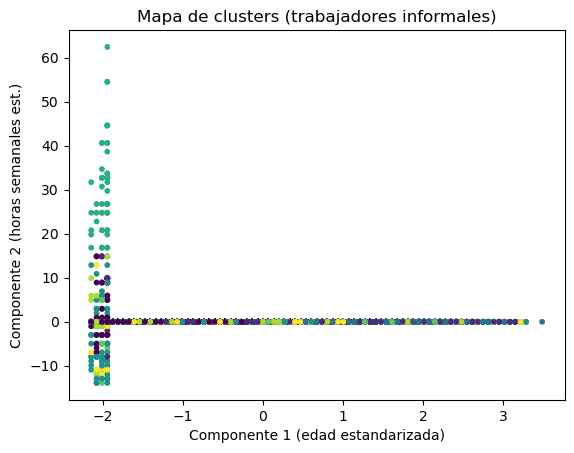

In [19]:
#trab["informal"].value_counts(normalize=True)
# =========================================================
# 11. SEGMENTACIÓN DE TRABAJADORES INFORMALES (K-MEANS)
# =========================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 11.1 Filtrar solo informales
# ---------------------------------------------------------
df_inf = trab[trab["informal"] == 1].copy()

print("N° de trabajadores informales:", len(df_inf))


# ---------------------------------------------------------
# 11.2 Selección de variables para segmentación
# ---------------------------------------------------------
vars_cluster = [
    "edad",
    "horas_semana",
    "log_ingreso",
    "num_trab",
    "sexo",
    "rural",
    "edu_sup",
    "indep"
]

df_cluster = df_inf[vars_cluster].copy()

# Imputación por mediana (por seguridad)
for v in vars_cluster:
    df_cluster[v] = pd.to_numeric(df_cluster[v], errors="coerce")
    df_cluster[v] = df_cluster[v].fillna(df_cluster[v].median())


# ---------------------------------------------------------
# 11.3 Estandarización
# ---------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Dimensiones de matriz para clustering:", X_scaled.shape)


# ---------------------------------------------------------
# 11.4 Selección óptima de K usando Silhouette Score
# ---------------------------------------------------------
scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(X_scaled)
    
    # Silhouette usando solo una muestra para no matar la RAM
    score = silhouette_score(
        X_scaled,
        km.labels_,
        sample_size=2000,      # puedes bajar a 5000 si aún se queja
        random_state=123
    )
    scores[k] = score



print("\nSilhouette Scores por K:")
for k, s in scores.items():
    print(f"K={k}: {s:.4f}")

best_k = max(scores, key=scores.get)
print(f"\n>>> Número óptimo de clusters (según Silhouette): K = {best_k}")


# ---------------------------------------------------------
# 11.5 Ejecutar K-means final
# ---------------------------------------------------------
kmeans = KMeans(n_clusters=best_k, random_state=123)
df_inf["cluster"] = kmeans.fit_predict(X_scaled)

print("\n===============================")
print("     TAMAÑO DE CADA CLUSTER")
print("===============================")
print(df_inf["cluster"].value_counts())


# ---------------------------------------------------------
# 11.6 Descripción de cada cluster
# ---------------------------------------------------------
print("\n===============================")
print(" DESCRIPCIÓN DE LOS CLUSTERS")
print("===============================")

cluster_summary = df_inf.groupby("cluster")[vars_cluster].mean()
print(cluster_summary)


# ---------------------------------------------------------
# 11.7 Variables categóricas adicionales (sexo, rural)
# ---------------------------------------------------------
print("\n===============================")
print(" DISTRIBUCIÓN DE SEXO POR CLUSTER")
print("===============================")
print(df_inf.groupby("cluster")["sexo"].mean().rename("proporción_hombres"))


print("\n===============================")
print(" DISTRIBUCIÓN RURAL/URBANO POR CLUSTER")
print("===============================")
print(df_inf.groupby("cluster")["rural"].mean().rename("proporción_rural"))


# ---------------------------------------------------------
# 11.8 Graficar clusters (opcional)
# ---------------------------------------------------------
import matplotlib.pyplot as plt

plt.scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=df_inf["cluster"], cmap="viridis", s=10
)
plt.xlabel("Componente 1 (edad estandarizada)")
plt.ylabel("Componente 2 (horas semanales est.)")
plt.title("Mapa de clusters (trabajadores informales)")
plt.show()


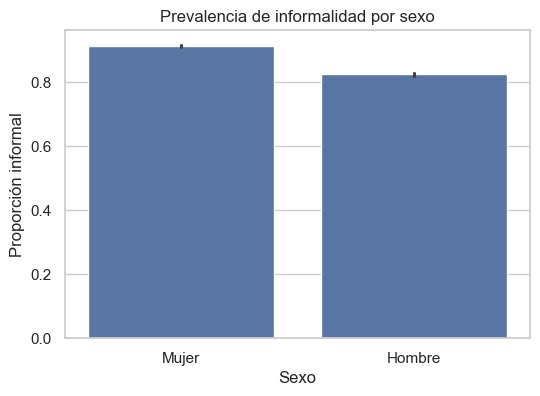

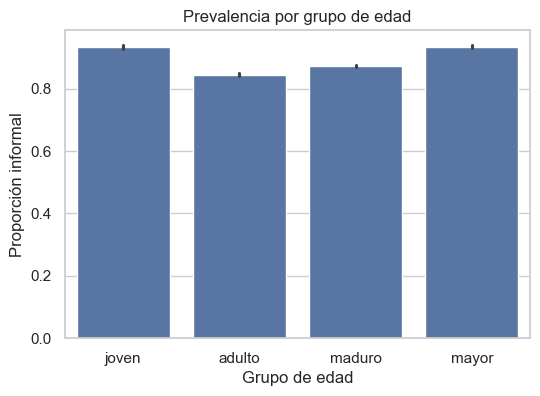

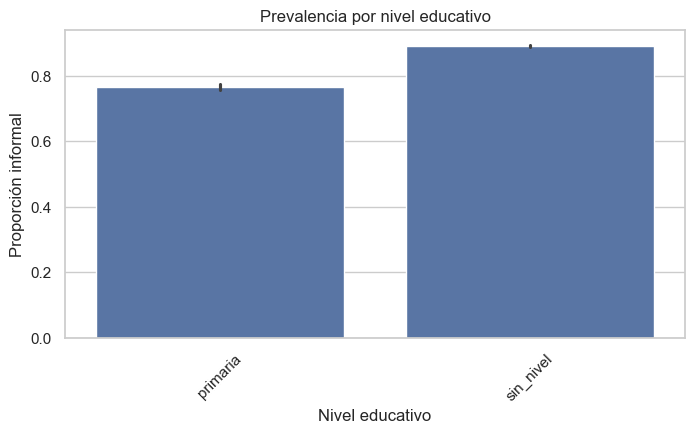

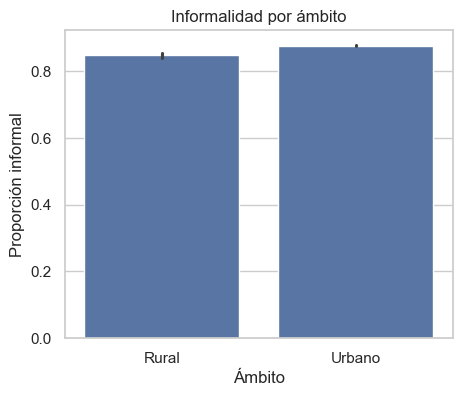

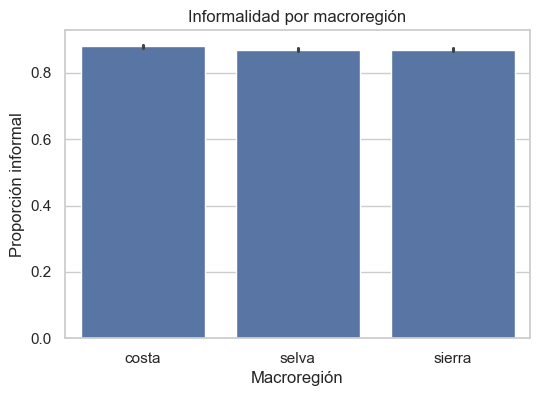

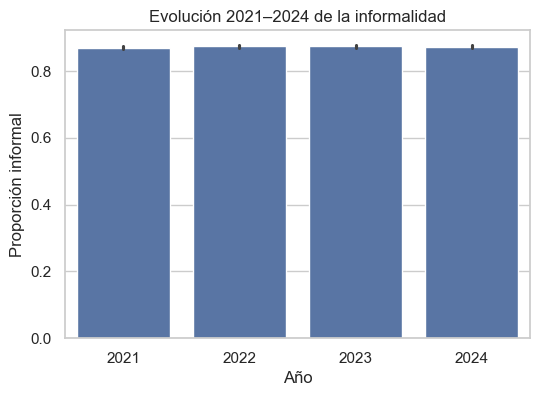

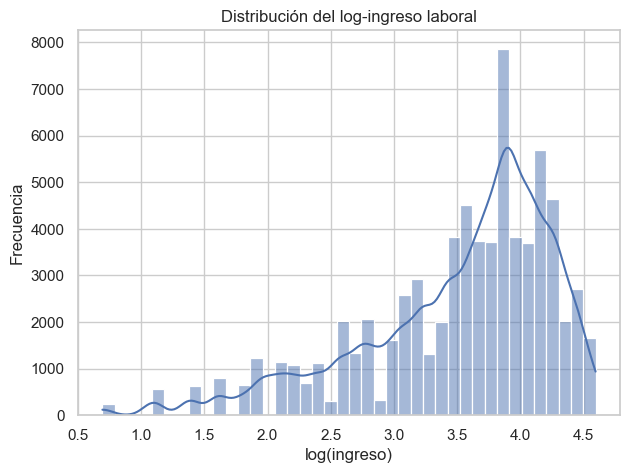

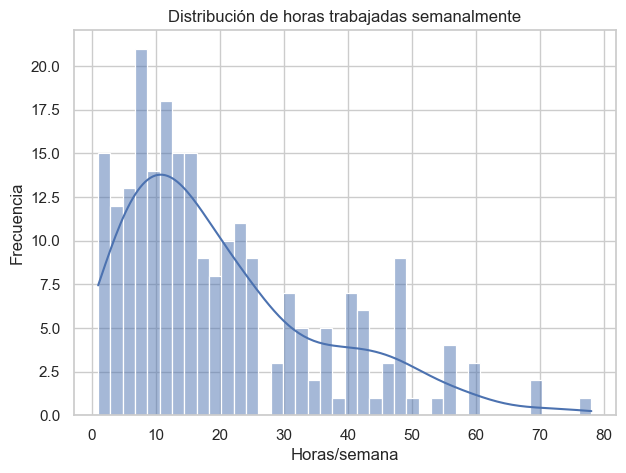

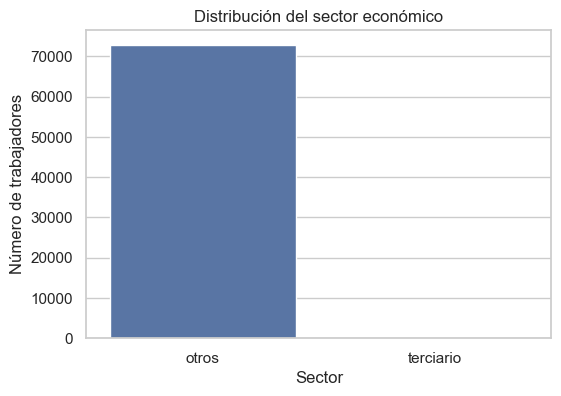

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Crear etiquetas legibles para algunas variables

# Sexo: 0 = Mujer, 1 = Hombre
trab["sexo_label"] = trab["sexo"].map({0: "Mujer", 1: "Hombre"})

# Por si acaso, aseguremos tipos categóricos útiles
trab["edad_grupo"] = trab["edad_grupo"].astype("category")
trab["edu_nivel"] = trab["edu_nivel"].astype("category")
trab["ambito"] = trab["ambito"].astype("category") if "ambito" in trab.columns else trab["rural"].map({0:"Urbano",1:"Rural"})
trab["macroregion"] = trab["macroregion"].astype("category")
trab["anio"] = trab["anio"].astype(str)  # para que salga como categoría
trab["sector_economico"] = trab["sector_economico"].astype("category")


sns.set(style="whitegrid")

# ================================
# 1. Informalidad por sexo
# ================================
plt.figure(figsize=(6,4))
sns.barplot(data=trab, x="sexo_label", y="informal", estimator="mean")
plt.title("Prevalencia de informalidad por sexo")
plt.ylabel("Proporción informal")
plt.xlabel("Sexo")
plt.show()

# ================================
# 2. Informalidad por grupo de edad
# ================================
plt.figure(figsize=(6,4))
sns.barplot(data=trab, x="edad_grupo", y="informal", estimator="mean")
plt.title("Prevalencia por grupo de edad")
plt.ylabel("Proporción informal")
plt.xlabel("Grupo de edad")
plt.show()

# ================================
# 3. Informalidad por nivel educativo
# ================================
plt.figure(figsize=(8,4))
sns.barplot(data=trab, x="edu_nivel", y="informal", estimator="mean")
plt.title("Prevalencia por nivel educativo")
plt.ylabel("Proporción informal")
plt.xlabel("Nivel educativo")
plt.xticks(rotation=45)
plt.show()

# ================================
# 4. Informalidad urbano vs rural
# ================================
plt.figure(figsize=(5,4))
sns.barplot(data=trab, x="ambito", y="informal", estimator="mean")
plt.title("Informalidad por ámbito")
plt.ylabel("Proporción informal")
plt.xlabel("Ámbito")
plt.show()

# ================================
# 5. Informalidad por macroregión
# ================================
plt.figure(figsize=(6,4))
sns.barplot(data=trab, x="macroregion", y="informal", estimator="mean")
plt.title("Informalidad por macroregión")
plt.ylabel("Proporción informal")
plt.xlabel("Macroregión")
plt.show()

# ================================
# 6. Informalidad por año
# ================================
plt.figure(figsize=(6,4))
sns.barplot(data=trab, x="anio", y="informal", estimator="mean")
plt.title("Evolución 2021–2024 de la informalidad")
plt.ylabel("Proporción informal")
plt.xlabel("Año")
plt.show()

# ================================
# 7. Distribución de ingresos (log ingreso)
# ================================
plt.figure(figsize=(7,5))
sns.histplot(trab["log_ingreso"], kde=True, bins=40)
plt.title("Distribución del log-ingreso laboral")
plt.xlabel("log(ingreso)")
plt.ylabel("Frecuencia")
plt.show()

# ================================
# 8. Distribución de horas semanales
# ================================
plt.figure(figsize=(7,5))
sns.histplot(trab["horas_semana"], kde=True, bins=40)
plt.title("Distribución de horas trabajadas semanalmente")
plt.xlabel("Horas/semana")
plt.ylabel("Frecuencia")
plt.show()

# ================================
# 9. Distribución del sector económico
# ================================
plt.figure(figsize=(6,4))
sns.countplot(data=trab, x="sector_economico")
plt.title("Distribución del sector económico")
plt.xlabel("Sector")
plt.ylabel("Número de trabajadores")
plt.show()


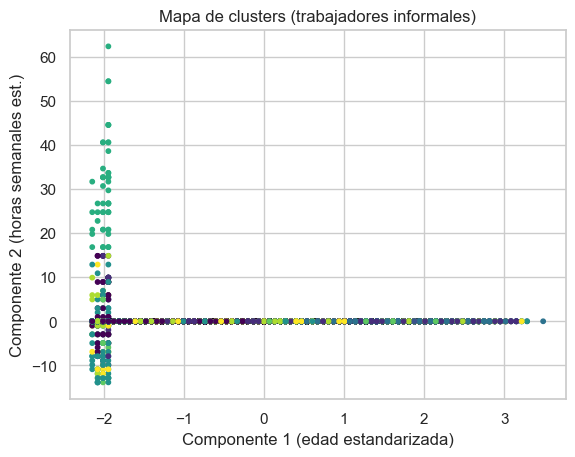

In [40]:
plt.scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=df_inf["cluster"], cmap="viridis", s=10
)
plt.xlabel("Componente 1 (edad estandarizada)")
plt.ylabel("Componente 2 (horas semanales est.)")
plt.title("Mapa de clusters (trabajadores informales)")
plt.show()